In [119]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [120]:
SIZE_X = 8
SIZE_Y = 8

In [121]:
G = nx.grid_2d_graph(range(SIZE_X), range(SIZE_Y))
for u, v, d in G.edges(data = True):
    d['weight'] = np.random.randint(1, 10)

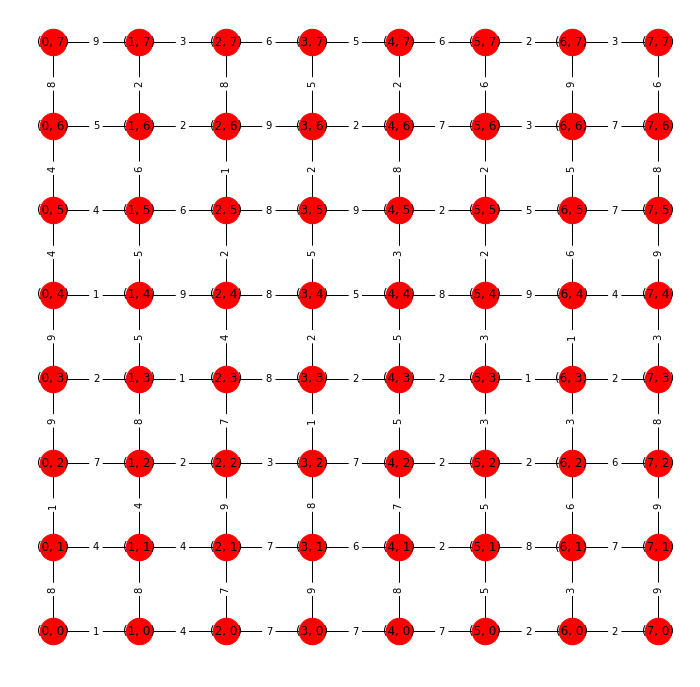

In [122]:
pos = {x: x for x in list(G)}
plt.figure(figsize=(12,12)) 
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, labels)
plt.axis('off')
plt.show()

In [123]:
cut_value, partition = nx.stoer_wagner(G)

In [124]:
print(nx.clustering(G,weight = 'weight'))

{(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (5, 0): 0, (5, 1): 0, (5, 2): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0, (5, 6): 0, (5, 7): 0, (6, 0): 0, (6, 1): 0, (6, 2): 0, (6, 3): 0, (6, 4): 0, (6, 5): 0, (6, 6): 0, (6, 7): 0, (7, 0): 0, (7, 1): 0, (7, 2): 0, (7, 3): 0, (7, 4): 0, (7, 5): 0, (7, 6): 0, (7, 7): 0}


In [125]:
DG = nx.DiGraph(G)

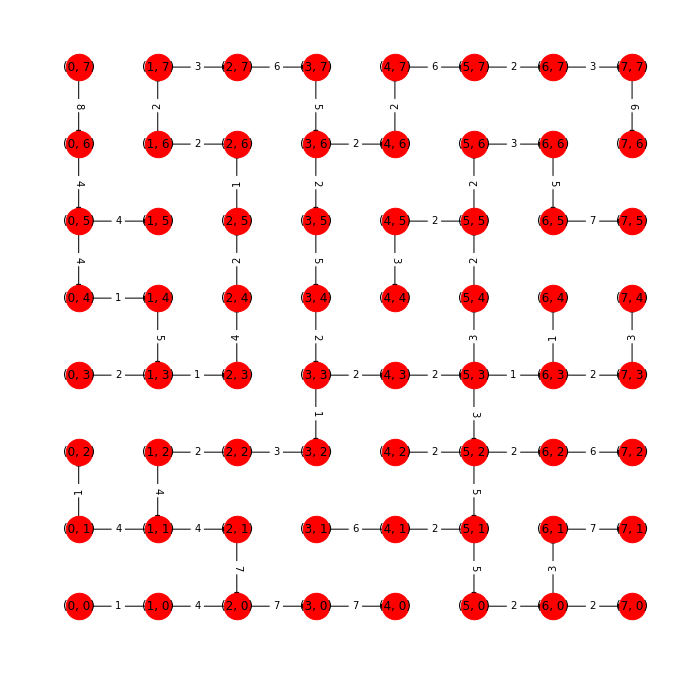

In [126]:
MST = nx.minimum_spanning_arborescence(DG)
plt.figure(figsize=(12,12)) 
nx.draw_networkx_nodes(MST, pos, node_size=700)
nx.draw_networkx_labels(MST, pos)
nx.draw_networkx_edges(MST, pos)
labels = nx.get_edge_attributes(MST, 'weight')
nx.draw_networkx_edge_labels(MST, pos, labels)
plt.axis('off')
plt.show()